In [127]:
import pandas as pd
import numpy as np
import math
import re
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import nltk
from nltk.collocations import (
    BigramCollocationFinder,
   
    BigramAssocMeasures,
    
)


In [128]:
nltk.download('punkt',quiet=True)
nltk.download('stopwords',quiet=True)

True

In [129]:
# Load your dataset
def load_data(file_path):
    """Load sentences from Excel file"""
    df = pd.read_excel(file_path,header=None)
    sentences = df[0].tolist()
    return sentences

In [130]:
sentences = load_data(r"../data/Sastra University.xlsx")
print(sentences[:3])

['Sastra University is located in Tamil Nadu.', 'Students at Sastra University engage in rigorous academic pursuits.', "The university's main campus, Sastra Tanjore, is known for its scenic beauty."]


In [131]:
def normalize_text(text):
    """Lowercase and convert to string"""
    return str(text).lower()


In [132]:
def clean_text(text):
    """Remove punctuation and extra whitespace"""
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [133]:
def tokenize_text(text):
    """Tokenize text with fallback"""
    try:
        return word_tokenize(text)
    except Exception:
        return text.split()


In [134]:
def preprocess_sentences(sentences, remove_stopwords=True):
    """
    Preprocess sentences for collocation analysis
    """
    preprocessed = []
    stop_words = set(stopwords.words('english')) if remove_stopwords else None

    for sentence in sentences:
        if pd.isna(sentence) or str(sentence).strip() == '':
            continue

        text = normalize_text(sentence)
        text = clean_text(text)
        tokens = tokenize_text(text)

        if tokens:
            preprocessed.append(tokens)

    print(f"\nPreprocessed {len(preprocessed)} sentences.")
    return preprocessed


In [135]:
sentenced_words = preprocess_sentences(sentences)


Preprocessed 50 sentences.


In [136]:
print(sentenced_words[:5])

[['sastra', 'university', 'is', 'located', 'in', 'tamil', 'nadu'], ['students', 'at', 'sastra', 'university', 'engage', 'in', 'rigorous', 'academic', 'pursuits'], ['the', 'university', 's', 'main', 'campus', 'sastra', 'tanjore', 'is', 'known', 'for', 'its', 'scenic', 'beauty'], ['sastra', 'university', 'offers', 'undergraduate', 'and', 'postgraduate', 'programs', 'in', 'diverse', 'disciplines'], ['sastra', 'university', 's', 'commitment', 'to', 'quality', 'education', 'is', 'evident', 'in', 'its', 'faculty']]


In [137]:
words = [word for sentence in sentenced_words for word in sentence]
N= len(words)

In [138]:
print(words[:6])

['sastra', 'university', 'is', 'located', 'in', 'tamil']


In [139]:
bigram_list = list(bigrams(words))

bigram_fd = FreqDist(bigram_list)

word_fd = FreqDist(words)

In [140]:
print(bigram_fd.most_common(50))

[(('sastra', 'university'), 32), (('university', 's'), 26), (('the', 'university'), 18), (('at', 'sastra'), 7), (('university', 'is'), 6), (('s', 'commitment'), 5), (('commitment', 'to'), 5), (('for', 'its'), 4), (('in', 'its'), 4), (('to', 'student'), 4), (('is', 'evident'), 3), (('evident', 'in'), 3), (('is', 'a'), 3), (('development', 'the'), 3), (('is', 'known'), 2), (('known', 'for'), 2), (('approach', 'to'), 2), (('with', 'industry'), 2), (('learning', 'the'), 2), (('department', 'of'), 2), (('is', 'highly'), 2), (('university', 'has'), 2), (('and', 'diverse'), 2), (('a', 'conducive'), 2), (('conducive', 'learning'), 2), (('learning', 'environment'), 2), (('university', 'promotes'), 2), (('emphasis', 'on'), 2), (('s', 'leadership'), 2), (('university', 'actively'), 2), (('actively', 'engages'), 2), (('skill', 'development'), 2), (('s', 'campus'), 2), (('s', 'admission'), 2), (('s', 'annual'), 2), (('is', 'located'), 1), (('located', 'in'), 1), (('in', 'tamil'), 1), (('tamil', 'na

In [141]:
def t_test_bigram(w1, w2):
    O = bigram_fd[(w1, w2)]
    N_bigram = N - 1

    if N_bigram <= 1:
        return 0

    # Sample mean
    x_bar = O / N_bigram

    # Expected mean under independence
    mu = (word_fd[w1] / N) * (word_fd[w2] / N)

    # Sample variance (Bernoulli)
    s2 = x_bar * (1 - x_bar)

    if s2 == 0:
        return 0

    # Standard error
    se = math.sqrt(s2 / N_bigram)

    # t-statistic
    t_stat = (x_bar - mu) / se

    return t_stat


In [142]:
test_bigrams = [
    ("sastra","university"),
    ('main','campus'),
    ('nuclear','fission')
]

In [143]:
def chi_square_bigram(w1, w2):
    if bigram_fd[(w1, w2)] == 0:
        return 0
    O11 = bigram_fd[(w1, w2)]
    O12 = word_fd[w1] - O11
    O21 = word_fd[w2] - O11
    O22 = N - (O11 + O12 + O21)

    total = O11 + O12 + O21 + O22

    E11 = (word_fd[w1] * word_fd[w2]) / total
    E12 = (word_fd[w1] * (total - word_fd[w2])) / total
    E21 = ((total - word_fd[w1]) * word_fd[w2]) / total
    E22 = ((total - word_fd[w1]) * (total - word_fd[w2])) / total

    chi2 = ((O11 - E11)**2 / E11) + ((O12 - E12)**2 / E12) + \
           ((O21 - E21)**2 / E21) + ((O22 - E22)**2 / E22)

    return chi2


In [144]:
bigram_finder = BigramCollocationFinder.from_words(words)

# Optional frequency filter (reduces noise)
bigram_finder.apply_freq_filter(1)

bigram_measures = BigramAssocMeasures()

# Compute all NLTK scores once
nltk_t_scores_bigram = dict(bigram_finder.score_ngrams(bigram_measures.student_t))
nltk_chi_scores_bigram = dict(bigram_finder.score_ngrams(bigram_measures.chi_sq))


REPORT GENERATION📄

In [145]:
results_bigrams = []
for w1, w2 in test_bigrams:
    bigram = (w1, w2)
    results_bigrams.append({
        "Bigram": f"{w1} {w2}",
        "Frequency": bigram_fd[bigram],
        "Manual t": round(t_test_bigram(w1, w2), 3),
        "NLTK t": round(nltk_t_scores_bigram.get(bigram, 0), 3),
        "Manual χ²": round(chi_square_bigram(w1, w2), 3),
        "NLTK χ²": round(nltk_chi_scores_bigram.get(bigram, 0), 3)
    })

df_bigrams = pd.DataFrame(results_bigrams)
print("\nBigram comparison:\n", df_bigrams)


Bigram comparison:
               Bigram  Frequency  Manual t  NLTK t  Manual χ²  NLTK χ²
0  sastra university         32     5.250   5.087    303.127  303.127
1        main campus          1     0.991   0.991    104.598  104.598
2    nuclear fission          0     0.000   0.000      0.000    0.000


VISUALIZER📈

(🎯 − 📏) ÷ ☁️

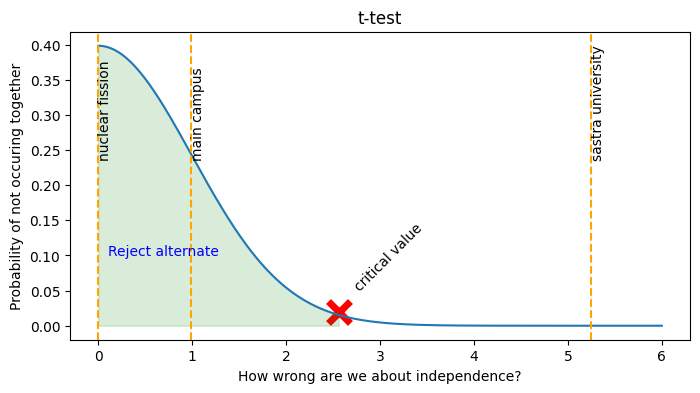

In [146]:
#Setting the scene
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

#Suspects
t_values = [5.25, 0.991,0,000]
labels = ["sastra university", "main campus","nuclear fission"]

#The Plains of Null
x = np.linspace(0, 6, 1000)
degFreedom = 349
y = t.pdf(
            x, 
            degFreedom
        )
plt.figure(figsize=(8,4))
plt.plot(x, y)

#Suspects on the scene
for tv, lbl in zip(t_values, labels):
    plt.axvline(
                    tv, 
                    linestyle='--',
                    color='orange'
                )
    plt.text(
                tv, 
                max(y)*0.6, 
                lbl, 
                rotation=90
            )

#The guilty threshold
plt.scatter(
                2.56,
                0.02, 
                marker='x',
                linewidth=5,
                s=250,
                color='red'
            )
plt.text(
            2.7, 
            0.05,
            "critical value",
            rotation=45
        )

#Mark of the not guilty territory
not_guilty_region_x = np.linspace(0, 2.56, 1000)
not_guilty_region_y = t.pdf(
                                not_guilty_region_x,
                                degFreedom
                            )
plt.fill_between(
                    not_guilty_region_x,
                    not_guilty_region_y,
                    color="green" ,
                    alpha=0.15)
plt.text(
            0.1,
            0.1,
            "Reject alternate",
            color="blue"
         )

#Verdict
plt.xlabel("How wrong are we about independence?")
plt.ylabel("Probability of not occuring together")
plt.title("t-test")

#Case closed
plt.show()


Σ (😬² ÷ 📏)

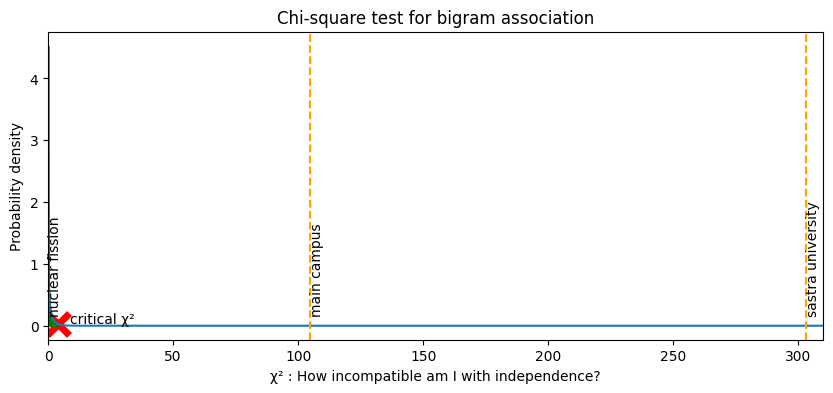

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

df = 1   # bigram association uses df = 1

x = np.linspace(0, 310, 1000)
y = chi2.pdf(x, df)

plt.figure(figsize=(10,4))
plt.plot(x, y)
plt.xlim(0, 310)

# observed chi-square values
chi_vals = [303.127, 104.598,0.000]
labels = ["sastra university", "main campus","nuclear fission"]

for cv, lbl in zip(chi_vals, labels):
    plt.axvline(cv, linestyle='--',color='orange')
    plt.text(cv, 0.2, lbl, rotation=90)

# critical value (α = 0.01)
crit = 3.84
plt.scatter(crit, chi2.pdf(crit, df), marker='x',color="red",linewidth=5 ,s=250)
plt.text(crit+5, chi2.pdf(crit, df), "critical χ²")

# rejection region shading
x_not_reject = np.linspace(0, crit, 500)
y_not_reject = chi2.pdf(x_not_reject, df)
plt.fill_between(x_not_reject, y_not_reject, alpha=1, color='green')

plt.xlabel("χ² : How incompatible am I with independence?")
plt.ylabel("Probability density")
plt.title("Chi-square test for bigram association")


plt.show()

